In [1]:
# Not required in Colab
# !pip install --upgrade pip
# !pip3 install torch torchvision torchaudio torchtext torchdata
# %pip install -q -U --pre triton

# !git clone https://github.com/huggingface/diffusers
# %cd diffusers
# %pip install .

# `xformers` needs `setuptools` & `wheel` to build    
# %pip install transformers accelerate bitsandbytes

# %pip install --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

Cloning into 'diffusers'...
remote: Enumerating objects: 60783, done.
remote: Counting objects: 100% (783/783), done.
remote: Compressing objects: 100% (449/449), done.
remote: Total 60783 (delta 485), reused 499 (delta 287), pack-reused 60000
Receiving objects: 100% (60783/60783), 42.12 MiB | 1.59 MiB/s, done.
Resolving deltas: 100% (44179/44179), done.
/home/yungshun317/workspace/py/sdxl-image-generation/diffusers


/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Processing /home/yungshun317/workspace/py/sdxl-image-generation/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 263.1 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 1.6 MB/s eta 0:00:001.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.2/789.2 kB 5.5 MB/s eta 0:00:006.1 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:0031m26.1 MB/s eta 0:00:01
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2094270 sha256=7714d69803fcb5d726fd6e7df4398507012f23ac47ad5b541620349292b101e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-1j5qb_fx/wheels/54/3c/b0/b9b460c98968e2360233decad3f0f48b30de3fe9a30cf49e08
Successfully built diffusers
Note: you may need to rest

In [7]:
# %pip install -q accelerate transformers ftfy bitsandbytes gradio natsort safetensors xformers
import torch
from diffusers import StableDiffusionPipeline

# Dreambooth

- https://dreambooth.github.io/
- https://github.com/google/dreambooth
- https://huggingface.co/blog/dreambooth
- https://huggingface.co/docs/diffusers/en/training/dreambooth
- https://github.com/nitrosocke/dreambooth-training-guide
- https://hackmd.io/@S819bX5JSmWK3m7LDYppTw/rkz5UxpTj

In [2]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

In [4]:
seed = 36

In [5]:
from PIL import Image

def img_grid(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

## Training

Three components are needed:
1. unique identifier
2. class name
3. images

Instance prompt
a photo of [unique identifier] [class name]

Class prompt
> a photo of [class name]

The instance prompt will be as follows:
> a photo of zwx person

As the subject is a person, the class prompt will be as follows:
> a photo of a person

In [2]:
# %cd dreambooth
# %pip install -r requirements.txt

/home/yungshun317/workspace/py/sdxl-image-generation/dreambooth


/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Note: you may need to restart the kernel to use updated packages.


### Accelerate
`default_config.yaml`
```sh
{
  "compute_environment": "LOCAL_MACHINE",
  "debug": false,
  "distributed_type": "NO",
  "downcast_bf16": false,
  "enable_cpu_affinity": false,
  "machine_rank": 0,
  "main_training_function": "main",
  "mixed_precision": "fp16",
  "num_machines": 1,
  "num_processes": 1,
  "rdzv_backend": "static",
  "same_network": false,
  "tpu_use_cluster": false,
  "tpu_use_sudo": false,
  "use_cpu": false
}
```

In [2]:
# Initialize an Accelerate environment
!accelerate config default --help

usage: accelerate config default [-h]
                                                    [--config_file SAVE_LOCATION]
                                                    [--mixed_precision {no,fp16,bf16}]

options:
  -h, --help            show this help message and exit
  --config_file SAVE_LOCATION, --config-file SAVE_LOCATION
                        The path to use to store the config file. Will default
                        to a file named default_config.yaml in the cache
                        location, which is the content of the environment
                        `HF_HOME` suffixed with 'accelerate', or if you don't
                        have such an environment variable, your cache
                        directory ('~/.cache' or the content of
                        `XDG_CACHE_HOME`) suffixed with 'huggingface'.
  --mixed_precision {no,fp16,bf16}, --mixed-precision {no,fp16,bf16}
                        Whether or not to use mixed precision training. Choose
           

In [2]:
!accelerate config default --mixed_precision="fp16"

Configuration already exists at /home/yungshun317/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### DreamBoothDataset & PromptDataset

- **DreamBoothDataset:** preprocesses the images and class images, and tokenizes the prompts for training
- **PromptDataset:** generates the prompt embeddings to generate the class images

In [2]:
import json, os, random

model_sd = "runwayml/stable-diffusion-v1-5"
output_dir = "/home/yungshun317/workspace/py/sdxl-image-generation/content/stable_diffusion_weights"

# Create the `stable_diffusion_weights` folder
!mkdir -p $output_dir

# Create the `instance_data_dir` folder & puts instance images inside
os.makedirs("/home/yungshun317/workspace/py/sdxl-image-generation/content/data/instance", exist_ok=True)

### Script Parameters
#### Model
- --pretrained_model_name_or_path: the name of the model on the Hub or a local path to the pretrained model
- --revision: Branches in **Files and Versions** of the pretrained model in Hugging Face Hub
- --instance_data_dir: path to a folder containing the training dataset (example images)
- --instance_prompt: the text prompt that contains the special word for the example images
- --output_dir: where to save the trained model

#### Training Loop
- --seed
- --resolution=512
- --train_batch_size=1: for `DreamBoothDataset`
- --sample_batch_size: for `PromptDataset`
- --gradient_accumulation_steps=1
- --learning_rate=5e-6
- --lr_scheduler="constant"
- --lr_warmup_steps=0
- --max_train_steps=400
- --mixed_precision="bf16"
- --prior_generation_precision="fp16"
- --enable_xformers_memory_efficient_attention
- --set_grads_to_none: set grads to None instead of zero

#### Checkpoints
- --push_to_hub: whether to push the trained model to the Hub
- --checkpointing_steps: frequency of saving a checkpoint as the model trains; this is useful if for some reason training is interrupted, you can continue training from that checkpoint by adding --resume_from_checkpoint to your training command

#### Min-SNR Weighting
- --snr_gamma: 5.0

#### Prior Preservation Loss
- --with_prior_preservation: whether to use prior preservation loss
- --prior_loss_weight: controls the influence of the prior preservation loss on the model
- --class_data_dir: path to a folder containing the generated class sample images
- --class_prompt: the text prompt describing the class of the generated sample images
- --num_class_images

#### Train Text Encoder
- --train_text_encoder: whether to also train the text encoder

#### Validation
- --validation_prompt="a photo of a sks dog"
- --num_validation_images=4
- --validation_steps=100

#### bitsandbytes
- --gradient_checkpointing
- --use_8bit_adam


In [3]:
!accelerate launch dreambooth/train_dreambooth.py --help

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/xformers/__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/xformers/triton/softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'
usage: train_dreambooth.py [-h] --pretrained_model_name_or_path
                           PRETRAINED_MODEL_NAME_OR_PATH [--revision REVISION]
                           [--variant VARIANT]
                           [--tokenizer_name TOKENIZER_NAME]
                           --instance_data_dir INSTANCE_DATA_DIR
                           [--class_data_dir CLASS_DATA_DIR] --instance_prompt
                           INSTANCE_PRO

In [10]:
instance_prompt = "a photo of sks dog"
class_prompt = "a photo of dog"
instance_data_dir = "/home/yungshun317/workspace/py/sdxl-image-generation/content/data/instance"
class_data_dir = "/home/yungshun317/workspace/py/sdxl-image-generation/content/data/class"

num_imgs = 5
# num_class_images = num_imgs * 12
# max_num_steps = num_imgs * 80
num_class_images = 200
max_num_steps = 800
learning_rate = 5e-6 # 0.0000001
# lr_warmup_steps = int(max_num_steps / 10)
lr_warmup_steps = 0
print(num_imgs, num_class_images, max_num_steps, learning_rate, lr_warmup_steps)

5 200 800 5e-06 0


In [11]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Apr 26 15:19:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P8               8W /  80W |     77MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
!accelerate launch dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$model_sd \
  --revision="fp16" \
  --instance_data_dir=$instance_data_dir \
  --instance_prompt=$instance_prompt \
  --output_dir=$output_dir \
  --snr_gamma=5.0 \
  --with_prior_preservation \
  --prior_loss_weight=1.0 \
  --class_data_dir=$class_data_dir \
  --class_prompt=$class_prompt \
  --num_class_images=$num_class_images \
  --seed=777 \
  --resolution=512 \
  --train_batch_size=1 \
  --sample_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=$max_num_steps \
  --mixed_precision="fp16" \
  --prior_generation_precision="fp16" \
  --gradient_checkpointing \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --set_grads_to_none

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/xformers/__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/xformers/triton/softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'
04/26/2024 15:19:24 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it vi

## Inference

In [4]:
# !pip3 install safetensors

In [2]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained(output_dir, torch_dtype=torch.float16, use_safetensors=True).to("cuda")
image = pipeline("A photo of sks dog in a bucket", num_inference_steps=50, guidance_scale=7.5).images[0]
image.save("images/dog-bucket.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

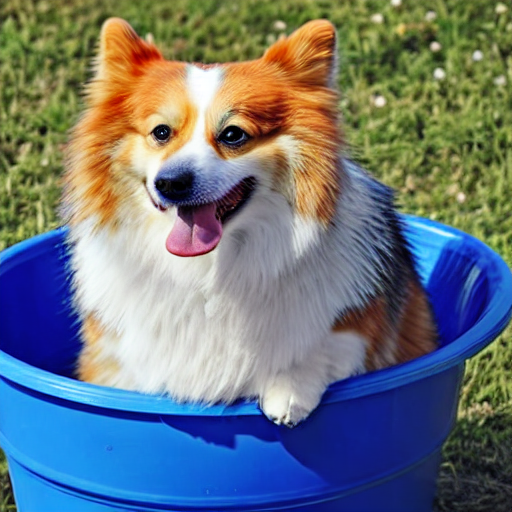

In [3]:
image

## Multiple Subjects

Shivam Shrirao's script supports multiple subject  
- https://github.com/ShivamShrirao/diffusers/blob/main/examples/dreambooth/train_dreambooth.py
- https://stable-diffusion-book.vercel.app/en/train/DreamBooth/#multiple-concept

### Arguments
- `concepts_list`: Path to json containing multiple concepts, will overwrite parameters like instance_prompt, class_prompt, etc.